In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pyaccel as pa
import pymodels as pm
from lattice_errors import generate_errors, apply_errors

from scipy.stats import norm, chi2, gamma

from mathphys.functions import save_pickle, load_pickle
from pyaccel.tracking import TrackingException
from apsuite.loco import LOCOUtils
from apsuite.orbcorr.calc_orbcorr_mat import OrbRespmat
from run_loco import create_loco_config, run_and_save, create_loco

## Useful functions

In [4]:
def make_diproll_angles_table(roll_angles, fam,n_stds=2):
    """."""
    subs = fam['BN']['subsection']
    b_id = fam['BN']['index']
    b1_id = fam['B1']['index']
    b2_id = fam['B2']['index']
    bc_id = fam['BC']['index']

    std = np.std(roll_angles)
    # df_sigma1 = pd.DataFrame({'angle':[], 'magnet':[], 'subsection':[]})
    df = pd.DataFrame(
        {'angle [mrad]': [], 'dipole_type': [], 'subsection': []})
    angles = []
    magnet = []
    subsection = []
    for i, angle in enumerate(roll_angles):
        #     if abs(angle) > std:
        #         sigma1.append(subs[i])
        if abs(angle) > n_stds*std:
            mag_idx = b_id[i]
            if mag_idx in b1_id:
                magnet.append('B1')
            elif mag_idx in b2_id:
                magnet.append('B2')
            else:
                magnet.append('BC')

            subsection.append(subs[i])
            angles.append(angle)

    df['angle [mrad]'] = angles
    df['dipole_type'] = magnet
    df['subsection'] = subsection
    return df


def plot_roll_angles(roll_angles):
    """."""
    roll_angles = np.copy(roll_angles) * 1e3  # rad to mrad
    std = np.std(roll_angles)
    with plt.style.context(['science', 'notebook']):
        plt.figure(figsize=(8, 4))
        plt.plot(roll_angles)
        plt.axhline(std, ls='dotted', label='1 $\sigma$')
        plt.axhline(-std, ls='dotted')
        plt.axhline(2*std, ls='--', label='2 $\sigma$')
        plt.axhline(-2*std, ls='--')
        plt.xlabel('Dipole idx')
        plt.ylabel('Roll angle [mrad]')
        plt.legend()


def calc_respmat(model):
    """."""
    fam = pm.si.get_family_data(model)
    orbmat = OrbRespmat(model, acc='SI', dim='6d')
    orbmat.ch_idx = np.array(fam['CH']['index']).ravel()
    orbmat.cv_idx = np.array(fam['CV']['index']).ravel()
    return -1e5*orbmat.get_respm()


def get_dispersion_vector(model=None):
    """."""
    if model is None:
        model = pm.si.create_accelerator()

    fam = pm.si.get_family_data(model)
    bpm_idx = fam['BPM']['index']
    twi, _ = pa.optics.calc_twiss(model)
    nom_disp = np.vstack([twi.etax[bpm_idx], twi.etay[bpm_idx]])[:, 0]
    return nom_disp


def dispersion_over_iterations(loco_outputs, loco_inputs=None, extra_title='', legend=True):
    """."""
    nom_disp = get_dispersion_vector()

    n = len(loco_outputs)
#     if loco_inputs is None:
#         respmats = \
#         [calc_respmat(loco_outputs[i]['fit_model']) for i in range(n)]
#         disp_type = 'Model dispersion after LOCO correction'
#     else:
#         respmats = [-0.1*loco_inputs[i]['respmat'] for i in range(n)]
#         disp_type = 'Measured dispersion after LOCO correction'

    with plt.style.context(['science', 'notebook']):
        fig, ax = plt.subplots(1, 2, figsize=(16, 4))

        for i, lout in enumerate(loco_outputs):
            disp = get_dispersion_vector(lout['fit_model'])
            ddisp = (nom_disp - disp)
            ax[0].plot(
                ddisp[:160]*1e2, label=f'iter {i}', c='C0',
                alpha=1/np.sqrt(len(loco_outputs)))
            ax[1].plot(
                ddisp[160:]*1e2, c='C1', alpha=1/np.sqrt(len(loco_outputs)),
                label=f'i={i}, $\chi^2 = {lout["chi_history"][-1]:.2f}$')

        ax[0].set_xlabel("BPM idx")
        ax[1].set_xlabel("BPM idx")
        ax[0].set_ylabel("$\Delta \eta_x [cm]$")
        ax[1].set_ylabel("$\Delta \eta_y [cm]$")
        if legend:
            ax[1].legend(bbox_to_anchor=(1, 0.8), fontsize=14)
#         fig.suptitle(disp_type+extra_title, fontsize=16)
        plt.tight_layout()
#         fig.show()
        return fig, ax

## Comparing the predicted errors for all LOCO inputs

Running default LOCO algorithm

In [10]:
directory = 'loco_inputs/'
for i, filename in enumerate(os.listdir(directory)):
    print(f"Iteration {i}")

    try:
        loco_roll = run_and_save(
        setup_name=directory + filename,
        file_name=f'loco_default_outputs/output{i}.pickle',
        niter=20,
        change_tunes=True,
        load_jacobian=False,
        save_jacobian=False,
        roll_dip=False)
    except TrackingException:
        print(f"Problem in output {i}: No orbit found")
    
    if i == 15:
        break

Iteration 0
--- correcting si tunes...
    tunes init  :  [49.09618826 14.15194311]
    tunes final :  [49.07774083 14.13715743]
svd_selection: all values will be used.
svd_selection: -1 values will be used.

Tracking dimension                 : 6d  
Include dispersion                 : True  
Include diagonal                   : True  
Include off-diagonal               : True  
Minimization method                : LevenbergMarquardt  
Lambda LM                          : 1.000000e-03  
Fixed lambda LM                    : 0.000000e+00  
Jacobian manipulation              : Transpose  
Constraint delta KL total          : False  
Constraint delta KL step           : True  
Singular values method             : Selection  
SV to be used:                     :  -1  
Tolerance delta                    : 1.000000e-06  
Tolerance overfit                  : 1.000000e-06  
H. kicks used to measure           : 15.00  [urad]
V. kicks used to measure           : 22.50  [urad]
RF freq. variation 

/home/facs/repos/pyaccel/pyaccel/lattice.py:1132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = _np.array(values)


chi: 1.734286 um
iter # 2/20
chi: 1.529323 um
iter # 3/20
chi: 1.516287 um
iter # 4/20
chi: 1.515459 um
iter # 5/20
chi: 1.515714 um
Finished!
running time: 3.6 minutes
Iteration 1
--- correcting si tunes...
    tunes init  :  [49.09618826 14.15194311]
    tunes final :  [49.07202362 14.1368721 ]
svd_selection: all values will be used.
svd_selection: -1 values will be used.

Tracking dimension                 : 6d  
Include dispersion                 : True  
Include diagonal                   : True  
Include off-diagonal               : True  
Minimization method                : LevenbergMarquardt  
Lambda LM                          : 1.000000e-03  
Fixed lambda LM                    : 0.000000e+00  
Jacobian manipulation              : Transpose  
Constraint delta KL total          : False  
Constraint delta KL step           : True  
Singular values method             : Selection  
SV to be used:                     :  -1  
Tolerance delta                    : 1.000000e-06  
Tole

In [ ]:
directory = 'loco_inputs/'
for i, filename in enumerate(os.listdir(directory)):
    print(f"Iteration {i}")

    try:
        loco_roll = run_and_save(
        setup_name=directory + filename,
        file_name=f'loco_roll_ouputs/output{i}_damped.pickle',
        niter=20,
        change_tunes=True,
        load_jacobian=False,
        save_jacobian=False,
        roll_dip=True)
    except TrackingException:
        print(f"Problem in output {i}: No orbit found")
    
    if i == 15:
        break

### Default algorithm VS Roll version

In [7]:
directory = 'loco_roll_ouputs/'
res_list = []
for filename in os.listdir(directory):
    if 'damped' not in filename:
        res_list.append(load_pickle(directory+filename))

roll_directory = 'loco_roll_ouputs/'
resroll_list = []
for filename in os.listdir(roll_directory):
    if 'damped' in filename:
        resroll_list.append(load_pickle(roll_directory+filename))

In [9]:
res_list[1]['config'].fit_dip_roll

True

### Dispersion comparison

In [9]:
dispy = []
dispy_roll = []

for res, resroll in zip(res_list, resroll_list):
    dispy.append(get_dispersion_vector(res['fit_model'])[160:])
    dispy_roll.append(get_dispersion_vector(resroll['fit_model'])[160:])
dispy = np.array(dispy) * 1e2  # m to cm
dispy_roll = np.array(dispy_roll) * 1e2  # m to cm

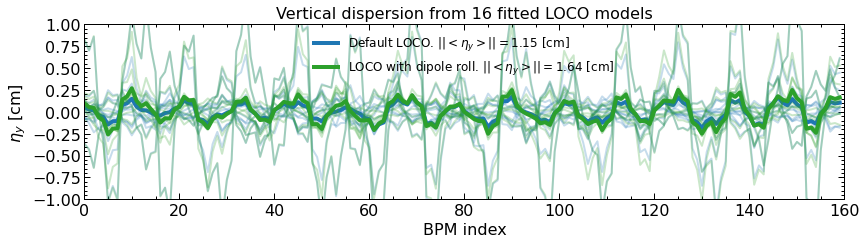

In [10]:
with plt.style.context(['science', 'notebook']):
    plt.figure(figsize=(12, 3.5))
    plt.plot(dispy.T, c='C0', alpha=1/np.sqrt(len(res_list)))
    plt.plot(
        dispy.mean(axis=0), c='C0',
        label=f'Default LOCO. $||<\eta_y>|| = {np.linalg.norm(dispy.mean(0)):.2f}$ [cm]',
        lw=4)

    plt.plot(dispy_roll.T, c='C2', alpha=1/np.sqrt(len(res_list)))
    plt.plot(
        dispy_roll.mean(axis=0), c='C2',
        label=f'LOCO with dipole roll. $||<\eta_y>|| = {np.linalg.norm(dispy_roll.mean(0)):.2f}$ [cm]',
        lw=4)
    
    plt.ylim([-1, 1])
    plt.xlim([0, 160])
    plt.title('Vertical dispersion from 16 fitted LOCO models')
    plt.xlabel('BPM index')
    plt.ylabel('$\eta_y$ [cm]')
    
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('figures/dispersion.png', facecolor='white',
                transparent=False, dpi=300)

### The $\chi^2$ comparison

In [18]:
n_meas = len(resroll_list)
max_iter = 20

chi_list = np.zeros([n_meas, max_iter])
chi_roll_list = np.zeros([n_meas, max_iter])

i=0
for res, resroll in zip(res_list, resroll_list):
    chi = res['chi_history']
    lenn = len(chi)
    chi_list[i, :lenn] = np.array(chi)
    chi_list[i, lenn:] = chi[-1]
    
    chi_roll = resroll['chi_history']
    lenroll = len(chi_roll)
    chi_roll_list[i, :lenroll] = np.array(chi_roll)
    chi_roll_list[i, lenroll:] = chi_roll[-1]
    i+=1

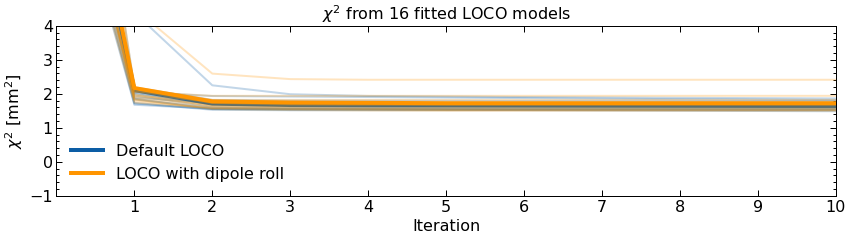

In [19]:
with plt.style.context(['science', 'notebook']):
    plt.figure(figsize=(12, 3.5))
    plt.plot(chi_list.T, c='C0', alpha=1/np.sqrt(len(res_list)))
    plt.plot(chi_list.mean(axis=0), c='C0', label='Default LOCO', lw=4)

    plt.plot(chi_roll_list.T, c='C2', alpha=1/np.sqrt(len(res_list)))
    plt.plot(chi_roll_list.mean(axis=0), c='C2', label='LOCO with dipole roll', lw=4)
    
    plt.xticks(np.arange(1,20))
    plt.ylim([-1, 4])
#     plt.semilogy()

    plt.xlim([0, 10])
    plt.title('$\chi^2$ from 16 fitted LOCO models')
    plt.xlabel('Iteration')
    
    plt.ylabel('$\chi^2$ [mm$^2$]')
    plt.tick_params(axis='x', which='minor', color='white')
    
    plt.legend()
    plt.tight_layout()
    plt.savefig('figures/chi2_over_iterations.png', facecolor='white',
                transparent=False, dpi=300)
    plt.show()

### Roll algorithm

In [20]:
directory = 'loco_roll_ouputs/'
res_list = []
for filename in os.listdir(directory):
    if 'damped' in filename:
        res_list.append(load_pickle(directory+filename))

Errors distribution along the ring

In [24]:
errors_dataset = np.array([res['roll_dip'] for res in res_list])

In [25]:
errors_mean = 1e3*errors_dataset.mean(axis=0)
erros_std = 1e3*errors_dataset.std(axis=0)

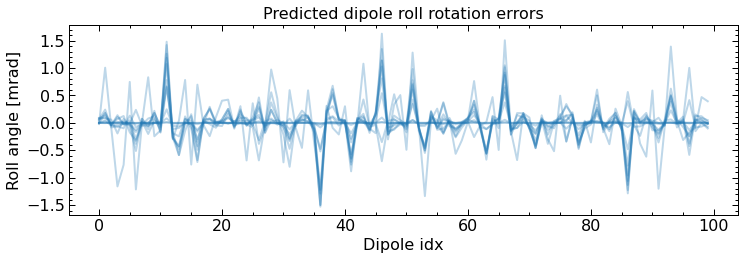

In [26]:
with plt.style.context(['science', 'notebook']):
    x = np.arange(len(errors_mean))
    plt.figure(figsize=(12, 3.5))
#     plt.plot(x, errors_mean, label='errors mean')
    plt.plot(1e3*errors_dataset.T, c='C0', alpha=1 /
             np.sqrt(errors_dataset.shape[0]))
#     plt.fill_between(
#         x, errors_mean + erros_std, errors_mean - erros_std, alpha=0.4, color='gray', label='errors std')
#     plt.legend(loc='lower left')
    plt.xlabel('Dipole idx')
    plt.ylabel('Roll angle [mrad]')
    plt.title('Predicted dipole roll rotation errors')
    plt.savefig('figures/stat_dip_errors.png', facecolor='white',
                transparent=False, dpi=300)

In [29]:
res_list[0]

array([-1.21183461e-06, -5.27394883e-06,  1.92261390e-07,  7.78718025e-07,
        2.98313277e-06, -2.09683475e-06, -1.56067258e-05,  1.96597657e-06,
       -4.17517066e-06, -1.19813726e-06,  3.85219465e-06,  8.15107170e-05,
       -1.39577415e-05, -1.32039372e-05, -1.01887177e-06, -5.62657623e-07,
       -2.34190794e-05,  2.82398604e-06,  5.35005365e-06,  1.94930075e-06,
       -1.20298793e-06, -1.25846008e-05,  1.14515880e-06, -3.62777902e-07,
       -2.14597432e-06,  4.25741910e-06,  2.82187392e-05, -6.12199193e-06,
       -3.13526063e-06, -3.24729967e-06,  1.20580205e-06, -6.95765878e-06,
       -4.77751660e-07,  4.87534249e-06,  3.89623518e-06, -7.46368037e-06,
       -8.39035542e-05,  1.26648612e-05,  1.50791096e-05,  3.16946067e-06,
        6.43660459e-07, -3.73714718e-05,  3.86803636e-06,  1.26906420e-06,
       -7.40145857e-06,  8.95747025e-06,  9.63266695e-05, -1.68062561e-05,
       -8.86060132e-06, -2.73176683e-07, -2.03705028e-06,  5.12341169e-05,
       -8.71907701e-06, -

Errors statistical distributions

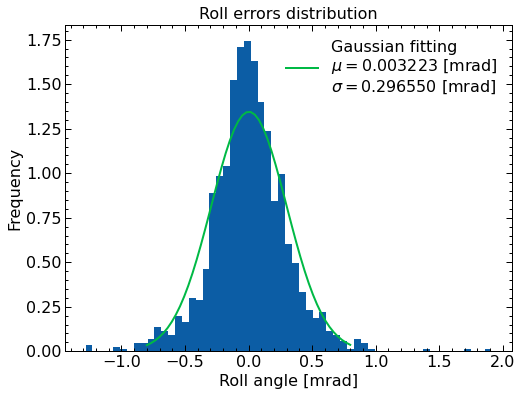

In [165]:
x = np.linspace(-0.8, 0.8)

errors_mean = errors_dataset.flatten()*1e3
# errors_mean = errors_dataset.mean(axis=0)*1e3

mu, std = norm.fit(errors_mean)

with plt.style.context(['science', 'notebook']):
    n, bins, parthces = plt.hist(errors_mean, bins='auto', density=True)
#     plt.annotate(
#         f'Distribution Params: \n$\cdot$ mean = {u:.3f} [mrad]\n$\cdot$ std = {sigma:.3f} [mrad]',
#         xy=(-0.75, 1.2), fontsize=14)
    plt.plot(x, norm.pdf(x, mu, std),
             label=f'Gaussian fitting\n$\mu={mu:2f}$ [mrad]\n$\sigma={std:2f}$ [mrad]')
    plt.title('Roll errors distribution')
    plt.xlabel('Roll angle [mrad]')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig('figures/mean_errors_distributionb.png',
                facecolor='white', transparent=False, dpi=300)

## Validating the model on simulated data

### Searching for a distribution to sample the BPM noise

In [171]:
bpmvar = loco_inputs[0]['bpm_variation']

In [300]:
bpmvar_xx = bpmvar[:160, :].ravel()
# bpmvar_xy = bpmvar[:160, 160:].ravel()
# bpmvar_yx = bpmvar[160:, :160].ravel()
bpmvar_yy = bpmvar[160:, :].ravel()

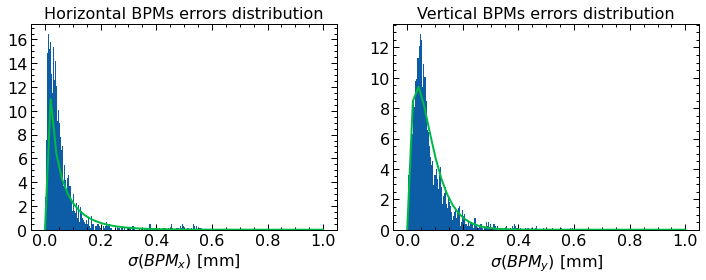

In [328]:
with plt.style.context(['science', 'notebook']):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    _ = ax[0].hist(bpmvar_xx, bins='auto', density=True, range=(0, 0.6))
    params = gamma.fit(bpmvar_xx[bpmvar_xx < 0.4])
    ax[0].plot(x, gamma.pdf(x, *params), label=f'{params}')

    _ = ax[1].hist(bpmvar_yy, bins='auto', density=True, range=(0, 0.6))
    ax[1].plot(x, gamma.pdf(x, *gamma.fit(bpmvar_yy[bpmvar_yy < 0.4])))
    ax[0].set_xlabel('$\sigma(BPM_x)$ [mm]')
    ax[1].set_xlabel('$\sigma(BPM_y)$ [mm]')
    ax[0].set_title('Horizontal BPMs errors distribution')
    ax[1].set_title('Vertical BPMs errors distribution')
    plt.tight_layout()

### Creating a model with errors

In [ ]:
acc = pm.si.create_accelerator()
fam_data = pm.si.get_family_data(acc)
um, mrad, percent = 1e-6, 1e-3, 1e-2
mags = []
dics = {}
dics['labels'] = ['QFA', 'QD', 'qfb']
dics['x'] = 40 * um * 1
dics['y'] = 40 * um * 1
dics['roll'] = 0.20 * mrad * 1
dics['excit'] = 0.05 * percent * 1
mags.append(dics)
dics = {}
dics['labels'] = ['b1', 'b2']
dics['x'] = 40 * um * 1
dics['y'] = 40 * um * 1
mags.append(dics)
girder = {}
girder['x'] = 100 * um * 1
girder['y'] = 100 * um * 1
girder['roll'] = 0.20 * mrad * 1
errors = generate_errors(acc, mags, girder, fam_data, nr_mach=20, cutoff=2)

In [21]:
mod = pm.si.create_accelerator()
print(pm.si.families.families_dipoles())
print(pm.si.families.families_quadrupoles())
print(pm.si.families.families_sextupoles())

['B1', 'B2', 'BC']
['QFA', 'QDA', 'QFB', 'QDB1', 'QDB2', 'QFP', 'QDP1', 'QDP2', 'Q1', 'Q2', 'Q3', 'Q4']
['SDA0', 'SDB0', 'SDP0', 'SDA1', 'SDB1', 'SDP1', 'SDA2', 'SDB2', 'SDP2', 'SDA3', 'SDB3', 'SDP3', 'SFA0', 'SFB0', 'SFP0', 'SFA1', 'SFB1', 'SFP1', 'SFA2', 'SFB2', 'SFP2']


In [18]:
famdata = pm.si.get_family_data(mod)

In [20]:
famdata['QFA']

{'index': [[18],
  [1286],
  [1310],
  [2578],
  [2600],
  [3872],
  [3896],
  [5174],
  [5199],
  [6476]],
 'subsection': ['01M2',
  '05M1',
  '05M2',
  '09M1',
  '09M2',
  '13M1',
  '13M2',
  '17M1',
  '17M2',
  '01M1'],
 'instance': ['', '', '', '', '', '', '', '', '', ''],
 'devnames': ['SI-01M2:PS-QFA',
  'SI-05M1:PS-QFA',
  'SI-05M2:PS-QFA',
  'SI-09M1:PS-QFA',
  'SI-09M2:PS-QFA',
  'SI-13M1:PS-QFA',
  'SI-13M2:PS-QFA',
  'SI-17M1:PS-QFA',
  'SI-17M2:PS-QFA',
  'SI-01M1:PS-QFA']}

## Orbit correction after dipole roll rotation


In [129]:
from apsuite.loco import LOCOUtils, LOCOConfigSI
from apsuite.orbcorr import OrbitCorr

In [142]:
model = pm.si.create_accelerator()
model.cavity_on = True
model.radiation_on = 'damping'

fam_data = pm.si.get_family_data(model)
bidxs = fam_data['BN']['index']

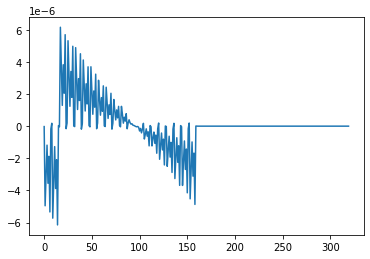

In [143]:
# Original orbit
oc = OrbitCorr(model, 'SI')
plt.plot(oc.get_orbit())

In [144]:
bidx = bidxs[0]
pa.lattice.set_error_rotation_roll(model, indices=bidx, values=1e-3)

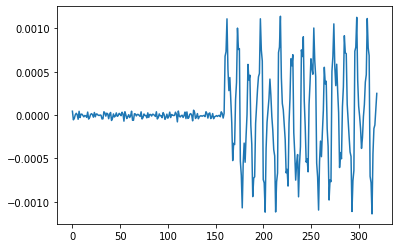

In [145]:
# Orbit with roll rotation 
plt.plot(oc.get_orbit())

In [146]:
oc.correct_orbit()

1

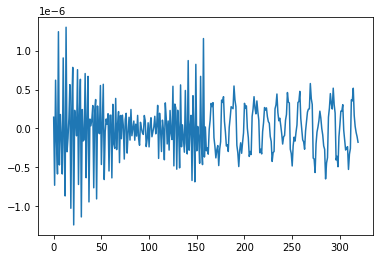

In [147]:
plt.plot(oc.get_orbit())

In [148]:
f = lambda x,y,z: x+y+z

### Testing LOCO submodules

In [175]:
model = pm.si.create_accelerator()
model.cavity_on = True
model.radiation_on = 'damping'

In [176]:
config = LOCOConfigSI()
config.DEFAULT_DELTA_MAG_ROLL_ANGLE = 1e-4
config.update_model(model=model, dim='6d')

In [ ]:
errors_list = np.logspace(-6, -3, 5)
results = []
for error in errors_list:
    
    config = LOCOConfigSI()
    config.DEFAULT_DELTA_MAG_ROLL_ANGLE = error
    config.update_model(model=model, dim='6d')
    # Jacobian computed without a roll error
    j0 = LOCOUtils.jloco_calc_dipoles_roll(config, model)

    # Jacobian computed with a roll error
    pa.lattice.set_error_rotation_roll(model, bidxs[0], config.DEFAULT_DELTA_MAG_ROLL_ANGLE)
    j1 = LOCOUtils.jloco_calc_dipoles_roll(config, model)

    # Relative error
    results.append(np.linalg.norm(j0-j1)/np.linalg.norm(j0))

In [183]:
results

[0.016444687383820714,
 0.09245957714019748,
 0.5163973489365854,
 2.415244615327565]

In [ ]:
np.linalg.norm(j1)

In [55]:
config.DEFAULT_DELTA_MAG_ROLL_ANGLE = 2e-7
j2 = LOCOUtils.jloco_calc_dipoles_roll(config, model)

In [56]:
j1norm = np.linalg.norm(j1)
j2norm = np.linalg.norm(j2)
# j3norm = np.linalg.norm(j3)